In [1]:
import cv2
import os
from keras.utils import np_utils
import numpy as np

Using TensorFlow backend.


In [2]:

    data_path='data'
    categories=os.listdir(data_path)
    labels=[i for i in range(len(categories))]

    label_dict=dict(zip(categories,labels))

    print(label_dict)
    print(categories)
    print(labels)

{'Angry': 0, 'Confused': 1, 'Happy': 2}
['Angry', 'Confused', 'Happy']
[0, 1, 2]


In [3]:
img_size=100
data=[]
target=[]


cascade= cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [4]:
    for category in categories:
        folder_path = os.path.join(data_path, category)
        img_names = os.listdir(folder_path)

        for img_name in img_names:
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            faces = cascade.detectMultiScale(img)
            try:
                for f in faces:
                    x, y, w, h = [v for v in f]#coordinate, and hight
                    sub_face = img[y:y + h, x:x + w]#croping the images, only to show the face
                    gray_image = cv2.cvtColor(sub_face, cv2.COLOR_BGR2GRAY)
                    resized = cv2.resize(gray_image, (img_size, img_size))
                    data.append(resized)
                    target.append(label_dict[category])
            except Exception as e:
                print('Exception:', e)

In [5]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

new_target=np_utils.to_categorical(target)

In [6]:
np.save('C:/Users/Atmabit/Emotion_Detection_Final/training/data',data)
np.save('C:/Users/Atmabit/Emotion_Detection_Final/training/target_data',new_target)

In [7]:
data=np.load('C:/Users/Atmabit/Emotion_Detection_Final/training/data.npy')
target=np.load('C:/Users/Atmabit/Emotion_Detection_Final/training/target_data.npy')

Now We will build the Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
model=Sequential()
model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
# #Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
# #Dense layer of 64 neurons
model.add(Dense(3,activation='softmax'))
# #The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 200)       2000      
_________________________________________________________________
activation (Activation)      (None, 98, 98, 200)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 100)       180100    
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 52900)             0

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)
#
checkpoint = ModelCheckpoint('./training/model-{epoch:03d}.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target, epochs=12,callbacks=[checkpoint],validation_split=0.2)


Epoch 1/12
15/15 [==============================] - 23s 2s/step - loss: 1.2846 - accuracy: 0.4147 - val_loss: 1.1132 - val_accuracy: 0.4035
Epoch 2/12
15/15 [==============================] - 22s 1s/step - loss: 1.0667 - accuracy: 0.4467 - val_loss: 1.0503 - val_accuracy: 0.4912
Epoch 3/12
15/15 [==============================] - 22s 1s/step - loss: 1.0325 - accuracy: 0.4922 - val_loss: 0.9726 - val_accuracy: 0.5614
Epoch 4/12
15/15 [==============================] - 22s 1s/step - loss: 0.9499 - accuracy: 0.5814 - val_loss: 0.8362 - val_accuracy: 0.5965
Epoch 5/12
15/15 [==============================] - 22s 1s/step - loss: 0.8063 - accuracy: 0.6492 - val_loss: 0.7263 - val_accuracy: 0.6842
Epoch 6/12
15/15 [==============================] - 22s 2s/step - loss: 0.7414 - accuracy: 0.6780 - val_loss: 0.6922 - val_accuracy: 0.6579
Epoch 7/12
15/15 [==============================] - 22s 1s/step - loss: 0.6948 - accuracy: 0.6905 - val_loss: 0.8171 - val_accuracy: 0.6140
Epoch 8/12
15/15 [==

In [14]:
import matplotlib.pyplot as plt

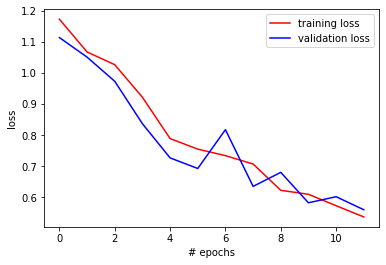

In [15]:
plt.plot(history.history['loss'], 'r' , label = 'training loss')
plt.plot(history.history['val_loss'], 'b' , label = 'validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
print(model.evaluate(test_data, test_target))

2/2 [==============================] - 1s 392ms/step - loss: 0.6634 - accuracy: 0.7344
[0.6634116172790527, 0.734375]


In [17]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

model=load_model('./training/model-012.h5')
face_clsfr= cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
cap1=cv2.VideoCapture("Vid1.mp4")
cap2=cv2.VideoCapture("My.mp4")

label_dict= {0:'Angry',1:'Confused',2:'Happy'}
color_dict={0:(0,0,255),1:(0,255,0),2:(255,0,255)}


In [18]:
while (True):

    ret, img = cap1.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_clsfr.detectMultiScale(gray, 1.3, 3)

    for (x, y, w, h) in faces:
        
        face_img = gray[y:y + w, x:x + w]
        resized = cv2.resize(face_img, (100, 100))
        normalized = resized / 255.0
        reshaped = np.reshape(normalized, (1, 100, 100, 1))
        result = model.predict(reshaped)

        label = np.argmax(result, axis=1)[0]

        cv2.rectangle(img, (x, y), (x + w, y + h), color_dict[label], 2)
        cv2.rectangle(img, (x, y - 40), (x + w, y), color_dict[label], -1)
        cv2.putText(img, label_dict[label], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    cv2.imshow('LIVE', img)
    #out.write(img)
    key = cv2.waitKey(1)

    if (key == 27):
        break
    if ret == False:
        break

cv2.destroyAllWindows()
cap1.release()


error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
